In [1]:
! pip install -q kaggle
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount("drive/")

Mounted at drive/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp "/content/drive/MyDrive/Kaggle API/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# recupérer les données à partir de kaggle
! kaggle datasets download "tom99763/affectnethq"


100% 8.12G/8.12G [01:17<00:00, 156MB/s]
100% 8.12G/8.12G [01:17<00:00, 112MB/s]


In [5]:
! unzip "/content/affectnethq.zip"

Streaming output truncated to the last 5000 lines.
  inflating: sad/image0027570.jpg    
  inflating: sad/image0027582.jpg    
  inflating: sad/image0027590.jpg    
  inflating: sad/image0027594.jpg    
  inflating: sad/image0027597.jpg    
  inflating: sad/image0027602.jpg    
  inflating: sad/image0027611.jpg    
  inflating: sad/image0027613.jpg    
  inflating: sad/image0027617.jpg    
  inflating: sad/image0027619.jpg    
  inflating: sad/image0027630.jpg    
  inflating: sad/image0027632.jpg    
  inflating: sad/image0027644.jpg    
  inflating: sad/image0027649.jpg    
  inflating: sad/image0027652.jpg    
  inflating: sad/image0027654.jpg    
  inflating: sad/image0027657.jpg    
  inflating: sad/image0027661.jpg    
  inflating: sad/image0027669.jpg    
  inflating: sad/image0027671.jpg    
  inflating: sad/image0027673.jpg    
  inflating: sad/image0027691.jpg    
  inflating: sad/image0027694.jpg    
  inflating: sad/image0027701.jpg    
  inflating: sad/image0027702.jpg    

In [3]:
import os
import shutil
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image


from sklearn.metrics import f1_score,precision_score, accuracy_score
from PIL import Image
from torchvision.transforms import transforms 



import torch.optim as optim
from torch.optim import lr_scheduler
from pathlib import Path
import math
import copy


In [4]:
os.mkdir("data")

In [5]:
! mv "/content/anger" "/content/data"
! mv "/content/disgust" "/content/data"
! mv "/content/contempt" "/content/data"
! mv "/content/fear" "/content/data"
! mv "/content/happy" "/content/data"
! mv "/content/sad" "/content/data"
! mv "/content/surprise" "/content/data"
! mv "/content/neutral" "/content/data"

In [6]:
os.listdir("/content/data")

['fear', 'disgust', 'contempt', 'happy', 'neutral', 'anger', 'surprise', 'sad']

In [7]:
df = pd.read_csv("/content/labels.csv")

In [8]:
df.head(3)

,pth,label
0,anger/image0000006.jpg,surprise
1,anger/image0000007.jpg,anger
2,anger/image0000012.jpg,anger


In [9]:
df.shape

(31002, 2)

In [10]:
df_attr = pd.concat([df['pth'],pd.get_dummies(df['label'])], axis=1)

# Creation du Data-Loader 

In [11]:
# Class to get data in specific format and preprocessing.
class EmoDataset(Dataset):
    def __init__(self,df_1,image_path,transform=None,mode='train'):
        super().__init__()
        self.attr=df_1.drop(['pth'],axis=1)
        self.path=image_path
        self.image_id=df_1['pth']
        self.transform=transform
        self.mode=mode
    def __len__(self):
        return self.image_id.shape[0]
    def __getitem__(self,idx:int):
        image_name=self.image_id.iloc[idx]
        image=Image.open(os.path.join(image_path,image_name))
        attributes=np.asarray(self.attr.iloc[idx].T,dtype=np.float32)
        if self.transform:
            image=self.transform(image)
        return image,attributes    

# Deviser en train test et validation 

In [12]:
df_attr.shape

(31002, 9)

In [13]:
from sklearn.model_selection import train_test_split
train_df,test=train_test_split(df_attr,test_size=0.1,shuffle=True,random_state=212)
valid_df,test_df=train_test_split(test,test_size=0.5,random_state=212)
train_df.shape,valid_df.shape,test_df.shape


((27901, 9), (1550, 9), (1551, 9))

# Preprocess des données

In [14]:
pretrained_means = [0.5341, 0.4345, 0.3872]
pretrained_stds= [0.2589, 0.2354, 0.2280]

In [15]:
# Appliquer l'augmentation des données et différents types de transformations sur les données du train.

train_transform=tt.Compose([tt.Resize((224,224)),
                                    tt.RandomHorizontalFlip(p=0.2),tt.ColorJitter(
                                        brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2
                                        ),
                                    tt.ToTensor(),
                                    tt.Normalize(mean=pretrained_means,
                                                         std=[0.2589, 0.2354, 0.2280])])

# Appliquer l'augmentation des données et différents types de transformations sur les données du validation

valid_transform=tt.Compose([tt.Resize((224,224)),
                              tt.ToTensor(),
                              tt.Normalize(mean=pretrained_means,
                                                   std=[0.2589, 0.2354, 0.2280])])

# Création de l'objet Dataset et le DataLoader pour les ensembles de train et de validation. 

In [16]:
train_df.head(2)

,pth,anger,contempt,disgust,fear,happy,neutral,sad,surprise
27088,surprise/ffhq_499.png,0,0,0,1,0,0,0,0
30966,surprise/image0034853.jpg,0,0,0,0,0,0,0,1


In [17]:
image_path='./data/'

In [18]:
train_data=EmoDataset(train_df,image_path,train_transform)
train_loader=DataLoader(train_data,batch_size=64,shuffle=True,num_workers=2)
valid_data=EmoDataset(valid_df,image_path,valid_transform)
valid_loader=DataLoader(valid_data,batch_size=64,num_workers=2)

# Visualisation d'une échantillon 

In [19]:
# fonction pour visualiser le dataset
def imshow(images,attr,idx:int):
    images=images.cpu().numpy().transpose((0,2,3,1))
    plt.imshow(images[idx]*[0.2644, 0.2436, 0.2397]+[0.5063, 0.4258, 0.3832])
    labels=df_attr.columns.tolist()
    labels=labels[1:]
    att=attr[idx].numpy()
    labels=[label for label,a in list(zip(labels,att)) if a==1]
    plt.xlabel("\n".join(labels))
    plt.show()


In [20]:
df_attr.columns.tolist()[1:]

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


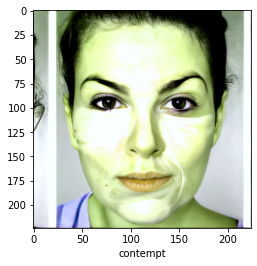

In [21]:
# visualisation
images,attr=next(iter(train_loader))
imshow(images,attr,0)

# Creation du modèle

## Conceptionde la Classe pour une seul couche (Layer).

In [22]:
class Layer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size=3,stride=1,padding=1):
        super(Layer,self).__init__()
        self.conv=nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding)
        self.bn=nn.BatchNorm2d(out_ch)
        self.relu=nn.ReLU()
        nn.init.xavier_uniform_(self.conv.weight)
    def forward(self,Input):
        output=self.conv(Input)
        output=self.bn(output)
        output=self.relu(output)
        return output

## Conception du modèle complet

In [23]:
class EmoModel(nn.Module):
    def __init__(self,num_classes=8):
        super(EmoModel,self).__init__()
        
        self.unit1=Layer(in_ch=3,out_ch=32)        
        self.unit2=Layer(in_ch=32,out_ch=32)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        
        self.unit3=Layer(in_ch=32,out_ch=64)
        self.unit4=Layer(in_ch=64,out_ch=64)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        
        self.unit5=Layer(in_ch=64,out_ch=128)
        self.unit6=Layer(in_ch=128,out_ch=128)
        self.unit7=Layer(in_ch=128,out_ch=128)
        self.pool3=nn.MaxPool2d(kernel_size=2)
        
        self.unit8=Layer(in_ch=128,out_ch=256,kernel_size=5,padding=0)
        self.unit9=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.unit10=Layer(in_ch=256,out_ch=256,kernel_size=5,padding=0)
        self.pool4=nn.MaxPool2d(kernel_size=2)
        
        self.drop2=nn.Dropout(0.5)   
        
        self.unit11=Layer(in_ch=256,out_ch=512,kernel_size=3,padding=0)
        self.unit12=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        self.unit13=Layer(in_ch=512,out_ch=512,kernel_size=3,padding=0)
        
        self.pool5=nn.AvgPool2d(kernel_size=2)
        
        self.drop3=nn.Dropout(0.5)
        
        self.model=nn.Sequential(self.unit1,self.unit2,self.pool1,self.unit3,
                                 self.unit4,self.pool2,self.unit5,self.unit6,
                                 self.unit7,self.pool3,self.unit8,self.unit9,
                                 self.unit10,self.pool4,self.drop2,self.unit11,
                                 self.unit12,self.unit13,self.pool5,self.drop3)
        
        self.fc=nn.Linear(in_features=512,out_features=num_classes)
        
    def forward(self,Input):
        
        output=self.model(Input)
        output=output.view(-1,512)
        output=self.fc(output)
        
        return output

# Preparation de l'environment

In [24]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creation de l'obejt modèle, de la fonction de perte (Loss function), de l'optimiseur, et du scheduler

In [25]:
# Creating Model Object,loss function,optimizer and scheduler
model=EmoModel().to(device)
criterion=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
scheduler=optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0000001, max_lr=1,mode='exp_range')

In [26]:
# # Creating Model Object,loss function,optimizer and scheduler
# model=EmoModel().to(device)
# criterion=nn.CrossEntropyLoss()
# optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9)
# scheduler=optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0000001, max_lr=1,mode='exp_range')

# Phase d'apprentissage 

In [27]:
# Création d'un checkpoint pour sauvegarder le modèle
def Save_model(model,cur_acc,best_acc,filename):
    if cur_acc>best_acc:
        best_acc=cur_acc
        best_model=copy.deepcopy(model)
        torch.save(best_model,filename)
    return best_acc


In [28]:
# Creation de la validation loop 
def val_model():
    model.eval()
    epoch_loss=0
    acc=0
    with torch.no_grad():
        val_pred=[]
        val_lbl=[]
        for images,attr in valid_loader:
            
            if torch.cuda.is_available():
                images=images.to(device)
                attr=attr.to(device)
            
            output=model(images)
            
            loss=criterion(output,attr)
            
            prediction=torch.round(torch.sigmoid(output))
            
            epoch_loss+=loss.item()*images.size(0)
            
            val_lbl.append(attr.detach().cpu())
            
            val_pred.append(prediction.detach().cpu()) 
            
        epoch_loss/=len(valid_data)
        
        acc=f1_score(torch.cat(val_lbl,dim=0).numpy(),torch.cat(val_pred,dim=0).numpy(),average='samples')
        
        return epoch_loss,acc    


In [29]:
# Creation du Training loop 

def train_model(num_epochs):
    train_loss=[]
    best_acc=0.0
    for i in range(num_epochs):
        epoch_loss=0
        acc=0
        j=0
        epoch_pred=[]
        epoch_lbl=[]
        model.train()
        for images,attr in train_loader:
            j+=1 
            if torch.cuda.is_available():
                images=images.to(device)
                attr=attr.to(device)
            
            optimizer.zero_grad()
            
            output=model(images)
            
            loss=criterion(output,attr)
            
            loss.backward()
            
            optimizer.step()
            
            prediction=torch.round(torch.sigmoid(output))
            
            epoch_loss+=loss.item()*images.size(0)
            
            epoch_lbl.append(attr.detach().cpu())
            
            epoch_pred.append(prediction.detach().cpu()) 
            
            torch.cuda.empty_cache()
            
            if (j+1)%10==0:
                print(f'Loss #{(j+1)//10}:{loss.item()}')
            
            scheduler.step()
            
        epoch_loss/=len(train_data)
        
        #acc=f1_score(torch.cat(epoch_lbl,dim=0).numpy(),torch.cat(epoch_pred,dim=0).numpy(),average='samples')

        acc = accuracy_score(torch.cat(epoch_lbl,dim=0).numpy(),torch.cat(epoch_pred,dim=0).numpy())

        train_loss.append(epoch_loss)
        
        val_loss,val_acc=val_model()
        
        best_acc=Save_model(model,val_acc,best_acc,'/content/drive/MyDrive/HETIC PFA/Models/emotion_model_enhanced-1-1.pth')   # save model
        Save_model(model,val_acc,best_acc,'emotion_model_enhanced.pth')   # save model
        print(f'Epoch : {i+1} , Training loss:{epoch_loss} , Training f1_score:{acc} , Validation loss:{val_loss} , Validation f1_score:{val_acc}')


In [30]:
! rm "/content/affectnethq.zip"

In [31]:
model_state = torch.load("/content/drive/MyDrive/HETIC PFA/Models/emotion_model_enhanced-1.pth", map_location=device)
model = model.eval()

In [ ]:
# Training
%%time
num_epochs=10
if __name__=='__main__':
    train_model(num_epochs)

Loss #1:0.6029892563819885
Loss #2:0.39553284645080566
Loss #3:0.4010632634162903
Loss #4:0.392083078622818
Loss #5:0.3839655816555023
Loss #6:0.3792669475078583
Loss #7:0.3730069100856781
Loss #8:0.38025856018066406
Loss #9:0.3557160198688507
Loss #10:0.3549855351448059
Loss #11:0.3531976044178009
Loss #12:0.36561232805252075
Loss #13:0.39291730523109436
Loss #14:0.37739893794059753
Loss #15:0.32913097739219666
Loss #16:0.3394036293029785
Loss #17:0.34031158685684204
Loss #18:0.33247479796409607
Loss #19:0.3501090109348297
Loss #20:0.3314657211303711
Loss #21:0.3311048746109009
Loss #22:0.3366914391517639
Loss #23:0.3284509778022766
Loss #24:0.33230650424957275
Loss #25:0.295343279838562
Loss #26:0.2852630615234375
Loss #27:0.3419278562068939
Loss #28:0.30240845680236816
Loss #29:0.2749598026275635
Loss #30:0.329948753118515
Loss #31:0.29100924730300903
Loss #32:0.29747486114501953
Loss #33:0.25251272320747375
Loss #34:0.29497629404067993
Loss #35:0.30420029163360596
Loss #36:0.315510